# Многоклассовая классификация и множественная классификация/регрессия
Ершов Владислав, 22.М07

# Задача

- [+] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
![multi_org_chart](https://scikit-learn.org/stable/_images/multi_org_chart.png)

- [+] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [+] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [+] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [+] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [+] Замерить время обучения каждой модели для каждой стратегии.
- [+] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [+] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.
- [+] (**+3 балла**) Повторить все пункты для задачи **Multilabel classification** (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать **MultiOutputClassifier** и **ClassifierChain**.
- [+] (**+2 балла**) Повторить все пункты для задачи **Multioutput Regression** (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: **Ridge**. В качестве стратегий попробовать **MultiOutputRegressor** и **RegressorChain**. В качестве метрики использовать **R2**.

## Multiclass classification
### Возьмем для примера виды стекла

Классификация стекла по типам
- Mg: Магний
- Al: Аллюминий
- Si: Силициум
- K: Калий
- Na: Натрий
- Ca: Кальций
- Ba: Барий
- Fe: Железо
- RI: показатель преломления
- Type of glass: (атрибут класса)
    - 1 окно здания обработано с плавающей запятой
    - 2 окна здания без плавающей обработки
    - 3 окна автомобиля обработаны плавающими движениями
    - 4 окна автомобиля без обработки с плавающей запятой (нет в этой базе данных)
    - 5 контейнеры
    - 6 посуда
    - 7 фары

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
df = pd.read_csv("./glass_types.csv")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Анализ

Рассмотим признак "Type of glass"

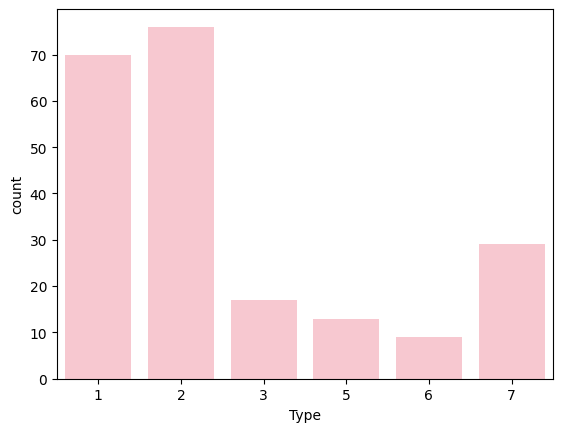

In [91]:
sns.countplot(x="Type", data=df, color="pink")
plt.show()

- Всего 7 типов
- Типы 1 и 2 - самые частые
- Тип 6 - наиболее редкий.

Рассмотрим корелляцию признаков.

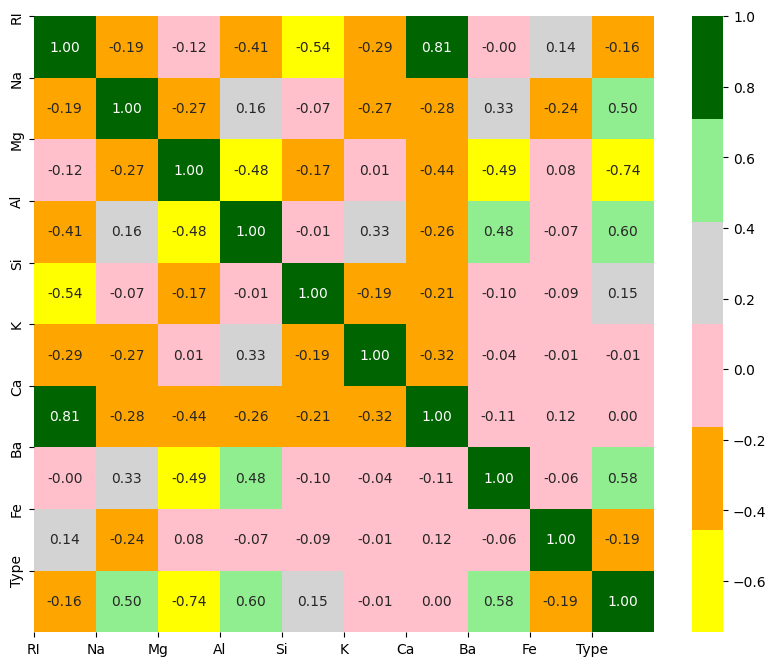

In [92]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.show()

Матрица показывает:
- кальций (Ca) кореллирует с показателем преломления (Refractive index)
- магний (Mg), алюминий (Al), барий (Ba) и натрий (Na) кореллируют с типом стекла

Рассмотрим какое количество образцов соответствует заданному количеству веществ.

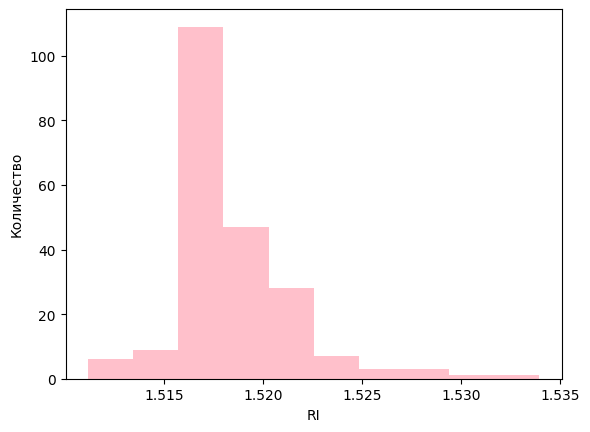

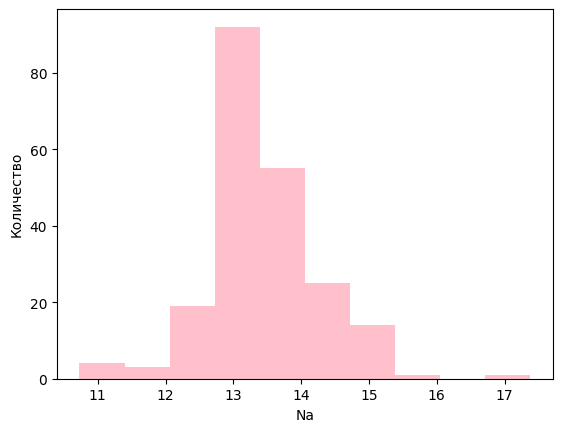

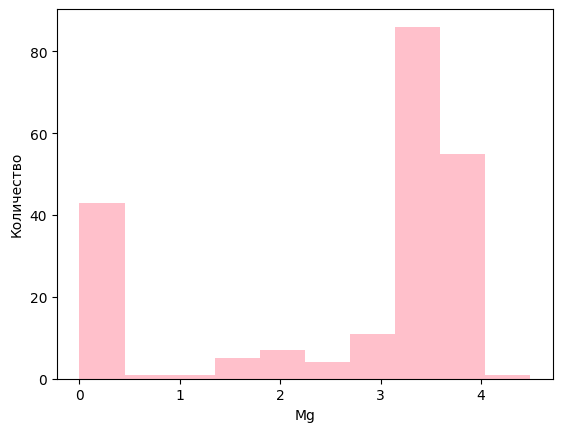

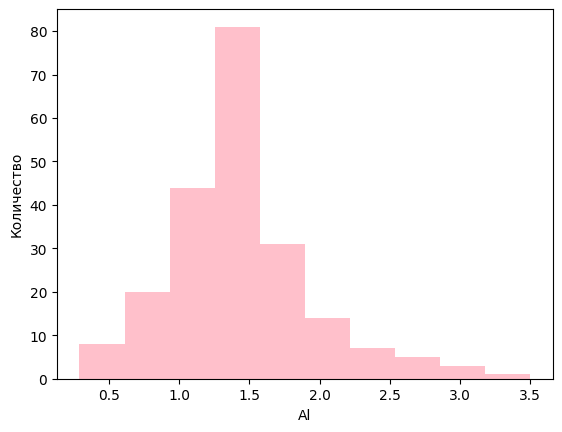

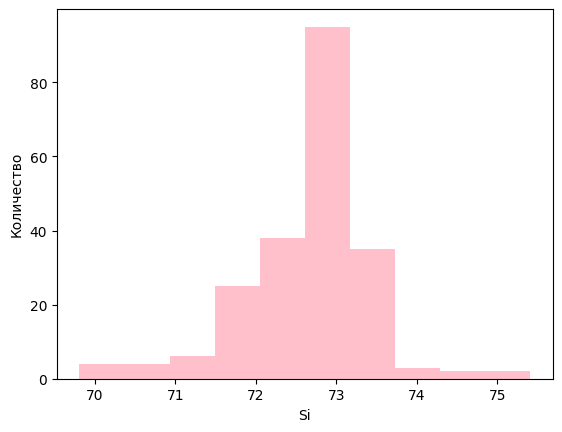

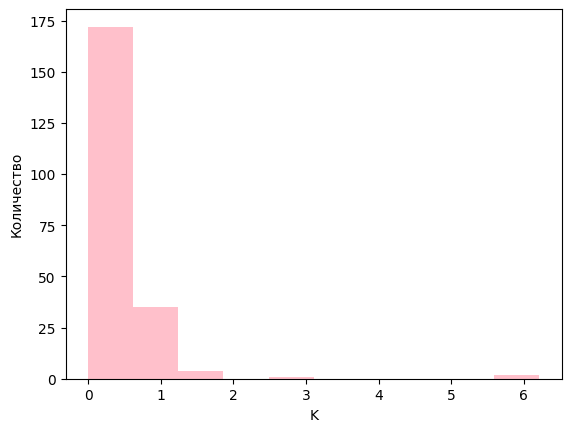

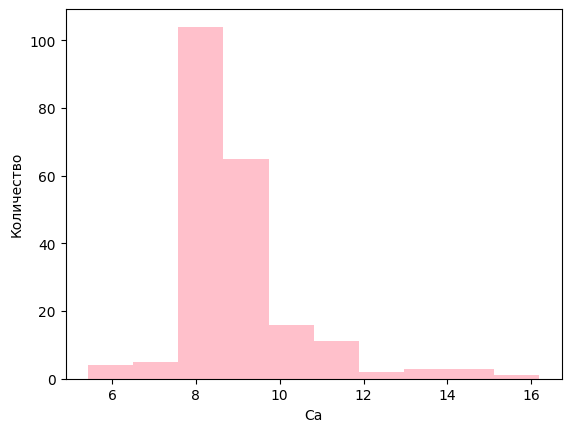

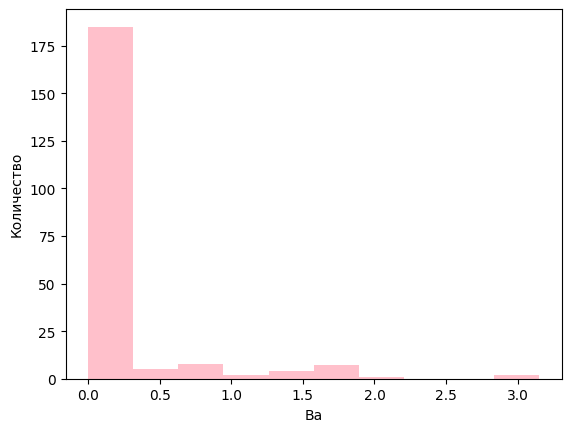

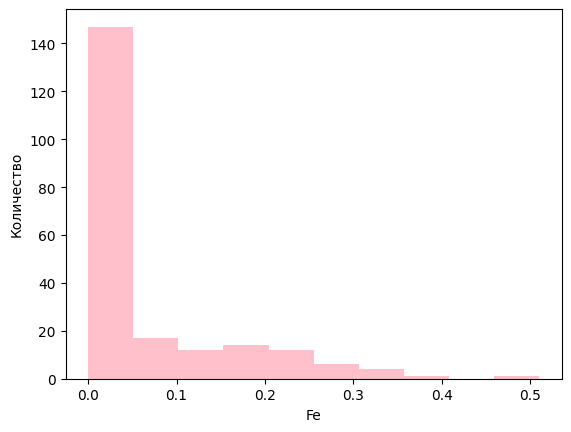

In [93]:
numerical = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe"]

for i in df[numerical].columns:
    plt.hist(df[numerical][i], color="pink")
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel("Количество")
    plt.show()    

Результаты:
- Показатель преломления (RI) для большей части образцов в интервале (1.515, 1.520)
- Количество натрия варьируется между 12 и 15, при этом у 80 образцов показатель равен 13
- Магний (Mg) у более чем 80 образцов от 3 до 4, также много образцов стекла вообще без содержания магния - чуть больше 40 проб
- Около 80 образцов содержат количество аллюминий (Al) в количестве 1.5
- Более 80 образцов содержат количество кремния (Si) в количестве 73
- Можно заметить, что количества содержания алюминия и кремния имеют нормальное распределение
- У большей части образцов нет в составе калия (K)
- Около 100 образцов содержат количество кальция (Ca) равное 8
- Также у большинство образцов нет в составе бария (Ba) и железа (Fe)

Рассмотрим количества различных образцов стекла в контексте зависимости от типа стекла

### Итог

Датасет не являются большими, также у рассмотренных признаков нет доминирующих значений, следовательно нет необходимости отбрасывать признаки или конструировать новые.

### Разбиение данных с использованием train_test_split и масштабирование

In [94]:
X = df.drop("Type", axis=1).values
y = df["Type"].values.reshape(-1, 1)

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train:  (160, 9)
Shape of X_test:  (54, 9)
Shape of y_train:  (160, 1)
Shape of y_test (54, 1)


### Обучение моделей

#### Logistic regression

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier


classifier_lr = LogisticRegression()
steps = [
    ("scalar", StandardScaler()),
    ("model", LogisticRegression(random_state=42))
]

lr_pipe = Pipeline(steps)

In [96]:
import time


parameters = { "model__C" : [1, 10, 100, 1000, 10000],
               "model__fit_intercept" : [True],
               "model__multi_class" : ["auto"],
               "model__tol" : [0.0001],
               "model__solver" : ["newton-cg", "lbfgs", "sag", "saga"],
               "model__n_jobs" : [-1],
               "model__max_iter" : [5000],
}

model = GridSearchCV(lr_pipe, parameters, scoring="roc_auc", cv=3)

classifier_lr_ovo = OneVsOneClassifier(model)
start_lr_ovo = time.time()
classifier_lr_ovo = classifier_lr_ovo.fit(X_train, y_train.ravel())
training_time_lr_ovo = time.time() - start_lr_ovo

classifier_lr_ovr = OneVsRestClassifier(model)
start_lr_ovr = time.time()
classifier_lr_ovr = classifier_lr_ovr.fit(X_train, y_train.ravel())
training_time_lr_ovr = time.time() - start_lr_ovr

classifier_lr_oc = OutputCodeClassifier(model)
start_lr_oc = time.time()
classifier_lr_oc = classifier_lr_oc.fit(X_train, y_train.ravel())
training_time_lr_oc = time.time() - start_lr_oc

Обучение ovo classifier:  0.7  время обучения:  29.77983856201172
Проверка ovo classifier:  0.6666666666666666


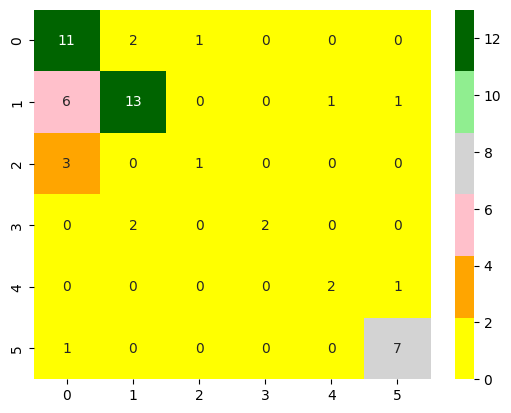

Обучение ovr classifier:  0.675  время обучения:  20.70228099822998
Проверка ovr classifier:  0.7407407407407407


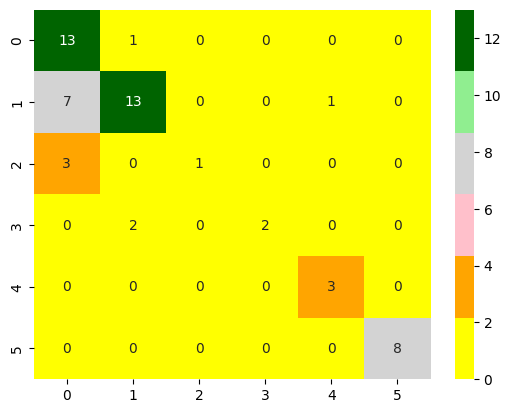

Обучение output code classifier:  0.6375  время обучения:  24.136395931243896
Проверка output code classifier:  0.6481481481481481


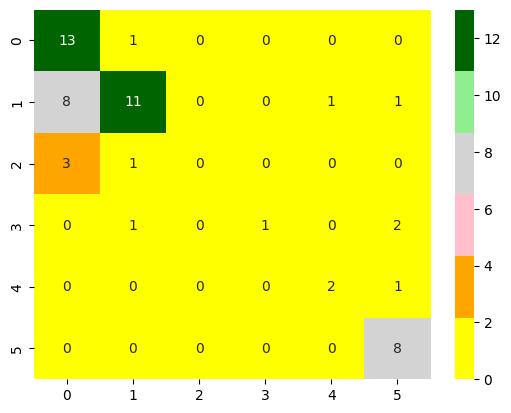

In [97]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


y_pred_lr_train = classifier_lr_ovo.predict(X_train)
accuracy_lr_train_ovo = accuracy_score(y_train, y_pred_lr_train)
print("Обучение ovo classifier: ", accuracy_lr_train_ovo, " время обучения: ", training_time_lr_ovo)

y_pred_lr_test = classifier_lr_ovo.predict(X_test)
accuracy_lr_test_ovo = accuracy_score(y_test, y_pred_lr_test)
print("Проверка ovo classifier: ", accuracy_lr_test_ovo)
sns.heatmap(confusion_matrix(y_test, y_pred_lr_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_lr_train = classifier_lr_ovr.predict(X_train)
accuracy_lr_train_ovr = accuracy_score(y_train, y_pred_lr_train)
print("Обучение ovr classifier: ", accuracy_lr_train_ovr, " время обучения: ", training_time_lr_ovr)

y_pred_lr_test = classifier_lr_ovr.predict(X_test)
accuracy_lr_test_ovr = accuracy_score(y_test, y_pred_lr_test)
print("Проверка ovr classifier: ", accuracy_lr_test_ovr)
sns.heatmap(confusion_matrix(y_test, y_pred_lr_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_lr_train = classifier_lr_oc.predict(X_train)
accuracy_lr_train_oc = accuracy_score(y_train, y_pred_lr_train)
print("Обучение output code classifier: ", accuracy_lr_train_oc, " время обучения: ", training_time_lr_oc)

y_pred_lr_test = classifier_lr_oc.predict(X_test)
accuracy_lr_test_oc = accuracy_score(y_test, y_pred_lr_test)
print("Проверка output code classifier: ", accuracy_lr_test_oc)
sns.heatmap(confusion_matrix(y_test, y_pred_lr_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()

#### KNN

In [111]:
from sklearn.neighbors import KNeighborsClassifier


classifier_knn = KNeighborsClassifier()
steps = [
    ("scalar", StandardScaler()),
    ("model", KNeighborsClassifier())
]
knn_pipe = Pipeline(steps)

In [112]:
parameters = { "model__algorithm" : ["brute"],
               "model__leaf_size" : [30, 50, 70, 90, 110],
               "model__metric" : ["minkowski"],
               "model__p" : [1],
               "model__n_neighbors" : [3, 5, 11, 19],
               "model__weights" : ["uniform", "distance"],
               "model__n_jobs" : [-1]
}
classifier_knn = GridSearchCV(knn_pipe, parameters, scoring="roc_auc", cv=3)

classifier_knn_ovo = OneVsOneClassifier(classifier_knn)
start_knn_ovo = time.time()
training_time_knn_ovo = time.time() - start_knn_ovo

classifier_knn_ovr = OneVsRestClassifier(classifier_knn)
start_knn_ovr = time.time()
training_time_knn_ovr = time.time() - start_knn_ovr

classifier_knn_oc = OutputCodeClassifier(classifier_knn)
start_knn_oc = time.time()
training_time_knn_oc = time.time() - start_knn_oc

Обучение ovo classifier:  0.91875  время обучения:  26.3143572807312
Проверка ovo classifier:  0.7777777777777778


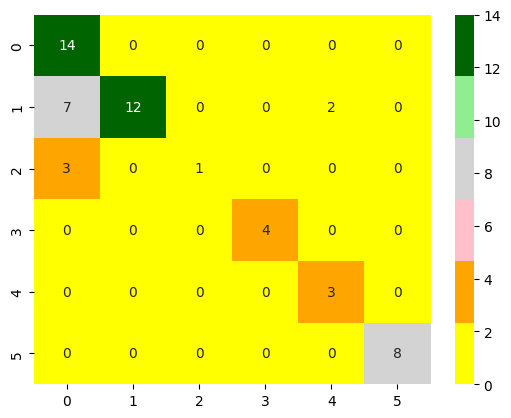

Обучение ovr classifier:   1.0  время обучения:  9.90174913406372
Проверка ovo classifier:  0.7407407407407407


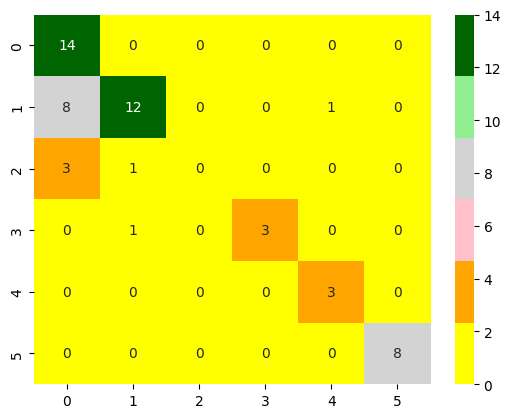

Обучение output code classifier:  1.0  время обучения:  15.09179973602295
Проверка output code classifier:   0.7407407407407407


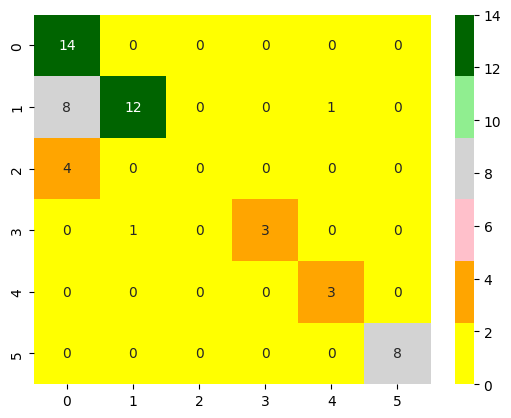

In [53]:
y_pred_knn_train = classifier_knn_ovo.predict(X_train)
accuracy_knn_train_ovo = accuracy_score(y_train, y_pred_knn_train)
print("Обучение ovo classifier: ", accuracy_knn_train_ovo, " время обучения: ", training_time_knn_ovo)
 
y_pred_knn_test = classifier_knn_ovo.predict(X_test)
accuracy_knn_test_ovo = accuracy_score(y_test, y_pred_knn_test)
print("Проверка ovo classifier: ", accuracy_knn_test_ovo)
sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_knn_train = classifier_knn_ovr.predict(X_train)
accuracy_knn_train_ovr = accuracy_score(y_train, y_pred_knn_train)
print("Обучение ovr classifier:  ", accuracy_knn_train_ovr, " время обучения: ", training_time_knn_ovr)

y_pred_knn_test = classifier_knn_ovr.predict(X_test)
accuracy_knn_test_ovr = accuracy_score(y_test, y_pred_knn_test)
print("Проверка ovo classifier: ", accuracy_knn_test_ovr)
sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_knn_train = classifier_knn_oc.predict(X_train)
accuracy_knn_train_oc = accuracy_score(y_train, y_pred_knn_train)
print("Обучение output code classifier: ", accuracy_knn_train_oc, " время обучения: ", training_time_knn_oc)

y_pred_knn_test = classifier_knn_oc.predict(X_test)
accuracy_knn_test_oc = accuracy_score(y_test, y_pred_knn_test)
print("Проверка output code classifier:  ", accuracy_knn_test_oc)
sns.heatmap(confusion_matrix(y_test, y_pred_knn_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()

#### SVM

In [54]:
from sklearn.svm import SVC


classifier_svm = SVC()
steps = [
    ("scalar", StandardScaler()),
    ("model", SVC(random_state=42))
]
svm_pipe = Pipeline(steps)

In [55]:
parameters = { "model__kernel" : ["linear"],
               "model__C" : [1, 10, 100, 1000, 10000],
               "model__random_state" : [42]
}
classifier_svm = GridSearchCV(svm_pipe, parameters, scoring="roc_auc", cv=3)

classifier_svm_ovo = OneVsOneClassifier(classifier_svm)
start_svm_ovo = time.time()
classifier_svm_ovo = classifier_svm_ovo.fit(X_train, y_train.ravel())
training_time_svm_ovo = time.time() - start_svm_ovo

classifier_svm_ovr = OneVsRestClassifier(classifier_svm)
start_svm_ovr = time.time()
classifier_svm_ovr = classifier_svm_ovr.fit(X_train, y_train.ravel())
training_time_svm_ovr = time.time() - start_svm_ovr

classifier_svm_oc = OutputCodeClassifier(classifier_svm)
start_svm_oc = time.time()
classifier_svm_oc = classifier_svm_oc.fit(X_train, y_train.ravel())
training_time_svm_oc = time.time() - start_svm_oc

Обучение ovo classifier:  0.73125  время обучения:  9.426422834396362
Проверка ovo classifier:  0.7407407407407407


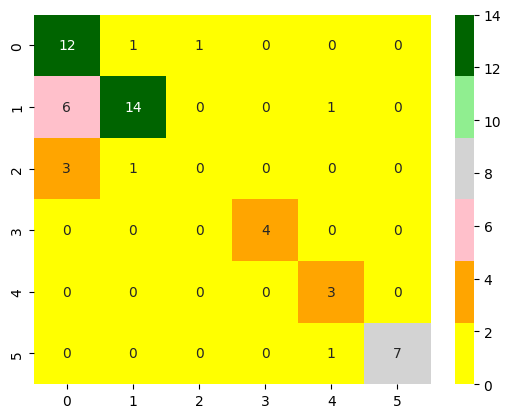

Обучение ovr classifier:  0.68125  время обучения:  116.2159972190857
Проверка ovr classifier:  0.6481481481481481


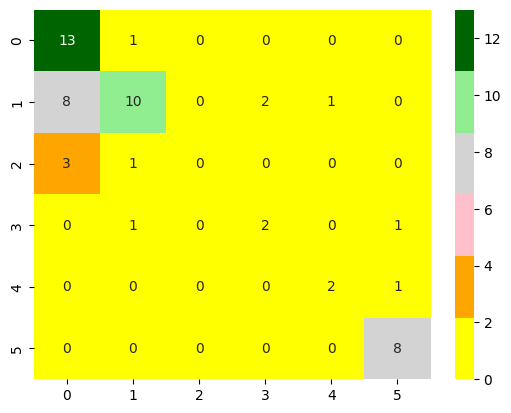

Обучение output code classifier:  0.65  время обучения:  153.16558456420898
Проверка output code classifier:  0.6296296296296297


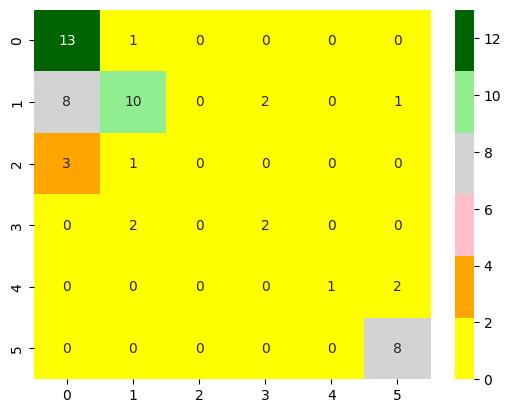

In [56]:
y_pred_svm_train = classifier_svm_ovo.predict(X_train)
accuracy_svm_train_ovo = accuracy_score(y_train, y_pred_svm_train)
print("Обучение ovo classifier: ", accuracy_svm_train_ovo, " время обучения: ", training_time_svm_ovo)

y_pred_svm_test = classifier_svm_ovo.predict(X_test)
accuracy_svm_test_ovo = accuracy_score(y_test, y_pred_svm_test)
print("Проверка ovo classifier: ", accuracy_svm_test_ovo)
sns.heatmap(confusion_matrix(y_test, y_pred_svm_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_svm_train = classifier_svm_ovr.predict(X_train)
accuracy_svm_train_ovr = accuracy_score(y_train, y_pred_svm_train)
print("Обучение ovr classifier: ", accuracy_svm_train_ovr, " время обучения: ", training_time_svm_ovr)

y_pred_svm_test = classifier_svm_ovr.predict(X_test)
accuracy_svm_test_ovr = accuracy_score(y_test, y_pred_svm_test)
print("Проверка ovr classifier: ", accuracy_svm_test_ovr)
sns.heatmap(confusion_matrix(y_test, y_pred_svm_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_svm_train = classifier_svm_oc.predict(X_train)
accuracy_svm_train_oc = accuracy_score(y_train, y_pred_svm_train)
print("Обучение output code classifier: ", accuracy_svm_train_oc, " время обучения: ", training_time_svm_oc)

y_pred_svm_test = classifier_svm_oc.predict(X_test)
accuracy_svm_test_oc = accuracy_score(y_test, y_pred_svm_test)
print("Проверка output code classifier: ", accuracy_svm_test_oc)
sns.heatmap(confusion_matrix(y_test, y_pred_svm_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()

#### Naive bayes

In [115]:
from sklearn.naive_bayes import GaussianNB


parameters = {"var_smoothing": np.logspace(0, -9, num=100)}
classifier_nb = GridSearchCV(GaussianNB(), parameters, scoring="roc_auc", cv=3)

classifier_nb_ovo = OneVsOneClassifier(classifier_nb)
start_nb_ovo = time.time()
training_time_nb_ovo = time.time() - start_nb_ovo

classifier_nb_ovr = OneVsRestClassifier(classifier_nb)
start_nb_ovr = time.time()
training_time_nb_ovr = time.time() - start_nb_ovr

classifier_nb_oc = OutputCodeClassifier(classifier_nb)
start_nb_oc = time.time()
training_time_nb_oc = time.time() - start_nb_oc

Обучение ovo classifier:  0.55  время обучения:  13.841963768005371
Проверка ovo classifier:  0.5555555555555556


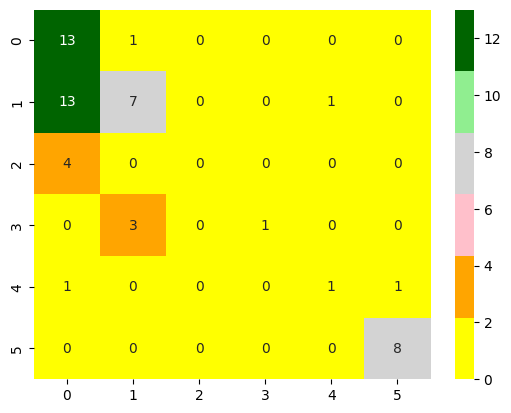

Обучение ovo classifier:  0.5625  время обучения:  8.855952501296997
Проверка ovo classifier:  0.5555555555555556


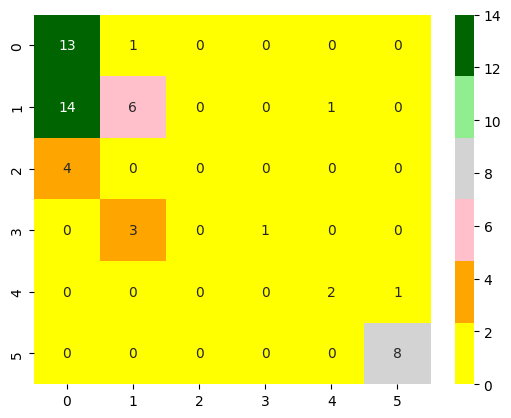

Обучение output code classifier:  0.44375  время обучения:  12.621654510498047
Проверка output code classifier:  0.48148148148148145


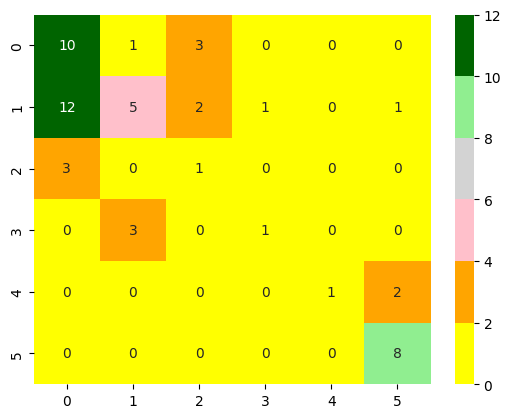

In [58]:
y_pred_nb_train = classifier_nb_ovo.predict(X_train)
accuracy_nb_train_ovo = accuracy_score(y_train, y_pred_nb_train)
print("Обучение ovo classifier: ", accuracy_nb_train_ovo, " время обучения: ", training_time_nb_ovo)

y_pred_nb_test = classifier_nb_ovo.predict(X_test)
accuracy_nb_test_ovo = accuracy_score(y_test, y_pred_nb_test)
print("Проверка ovo classifier: ", accuracy_nb_test_ovo)
sns.heatmap(confusion_matrix(y_test, y_pred_nb_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_nb_train = classifier_nb_ovr.predict(X_train)
accuracy_nb_train_ovr = accuracy_score(y_train, y_pred_nb_train)
print("Обучение ovo classifier: ", accuracy_nb_train_ovr, " время обучения: ", training_time_nb_ovr)

y_pred_nb_test = classifier_nb_ovr.predict(X_test)
accuracy_nb_test_ovr = accuracy_score(y_test, y_pred_nb_test)
print("Проверка ovo classifier: ", accuracy_nb_test_ovr)
sns.heatmap(confusion_matrix(y_test, y_pred_nb_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_nb_train = classifier_nb_oc.predict(X_train)
accuracy_nb_train_oc = accuracy_score(y_train, y_pred_nb_train)
print("Обучение output code classifier: ", accuracy_nb_train_oc, " время обучения: ", training_time_nb_oc)

y_pred_nb_test = classifier_nb_oc.predict(X_test)
accuracy_nb_test_oc = accuracy_score(y_test, y_pred_nb_test)
print("Проверка output code classifier: ", accuracy_nb_test_oc)
sns.heatmap(confusion_matrix(y_test, y_pred_nb_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()

#### DTC

In [59]:
from sklearn.tree import DecisionTreeClassifier


classifier_dtc = DecisionTreeClassifier()

steps = [
    ("scalar", StandardScaler()),
    ("model", DecisionTreeClassifier())
]
dt_pipe = Pipeline(steps)

In [60]:
parameters = [ { "model__max_depth": np.arange(1, 21),
                 "model__min_samples_leaf": [1, 5, 10, 20, 50, 100],
                 "model__min_samples_split": np.arange(2, 11),
                 "model__criterion": ["gini"],
                 "model__random_state" : [42]}
            ]
classifier_dtc = GridSearchCV(estimator=dt_pipe,
                           param_grid=parameters,
                           scoring="roc_auc", 
                           cv=3,
                           n_jobs=-1)

classifier_dtc_ovo = OneVsOneClassifier(classifier_dtc)
start_dtc_ovo = time.time()
classifier_dtc_ovo = classifier_dtc_ovo.fit(X_train, y_train.ravel())
training_time_dtc_ovo = time.time() - start_dtc_ovo

classifier_dtc_ovr = OneVsRestClassifier(classifier_dtc)
start_dtc_ovr = time.time()
classifier_dtc_ovr = classifier_dtc_ovr.fit(X_train, y_train.ravel())
training_time_dtc_ovr = time.time() - start_dtc_ovr

classifier_dtc_oc = OutputCodeClassifier(classifier_dtc)
start_dtc_oc = time.time()
classifier_dtc_oc = classifier_dtc_oc.fit(X_train, y_train.ravel())
training_time_dtc_oc = time.time() - start_dtc_oc

Обучение ovo classifier:  0.85  время обучения:  109.27729868888855
Проверка ovo classifier:  0.7222222222222222


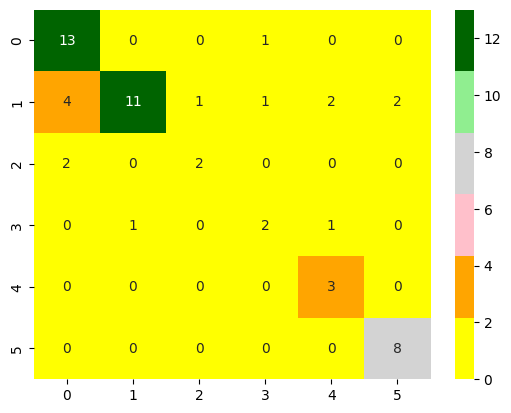

Обучение ovr classifier:  0.83125  время обучения:  34.330039262771606
Проверка ovr classifier:  0.7037037037037037


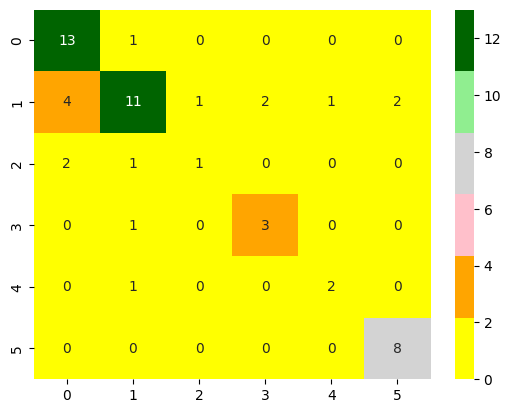

Обучение output code classifier:  0.8875  время обучения:  48.05967879295349
Проверка output code classifier:  0.6481481481481481


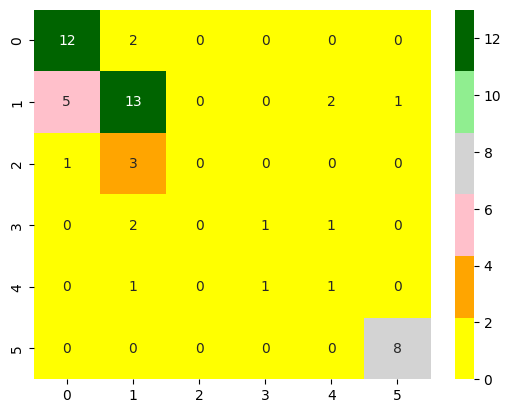

In [61]:
y_pred_dt_train = classifier_dtc_ovo.predict(X_train)
accuracy_dt_train_ovo = accuracy_score(y_train, y_pred_dt_train)
print("Обучение ovo classifier: ", accuracy_dt_train_ovo, " время обучения: ", training_time_dtc_ovo)

y_pred_dt_test = classifier_dtc_ovo.predict(X_test)
accuracy_dt_test_ovo = accuracy_score(y_test, y_pred_dt_test)
print("Проверка ovo classifier: ", accuracy_dt_test_ovo)
sns.heatmap(confusion_matrix(y_test, y_pred_dt_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_dt_train = classifier_dtc_ovr.predict(X_train)
accuracy_dt_train_ovr = accuracy_score(y_train, y_pred_dt_train)
print("Обучение ovr classifier: ", accuracy_dt_train_ovr, " время обучения: ", training_time_dtc_ovr)

y_pred_dt_test = classifier_dtc_ovr.predict(X_test)
accuracy_dt_test_ovr = accuracy_score(y_test, y_pred_dt_test)
print("Проверка ovr classifier: ", accuracy_dt_test_ovr)
sns.heatmap(confusion_matrix(y_test, y_pred_dt_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()


y_pred_dt_train = classifier_dtc_oc.predict(X_train)
accuracy_dt_train_oc = accuracy_score(y_train, y_pred_dt_train)
print("Обучение output code classifier: ", accuracy_dt_train_oc, " время обучения: ", training_time_dtc_oc)

y_pred_dt_test = classifier_dtc_oc.predict(X_test)
accuracy_dt_test_oc = accuracy_score(y_test, y_pred_dt_test)
print("Проверка output code classifier: ", accuracy_dt_test_oc)
sns.heatmap(confusion_matrix(y_test, y_pred_dt_test), annot=True, fmt=".0f", cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])
plt.show()

### Comparison models

In [116]:
models = [("Logistic Regression", accuracy_lr_train_ovo, accuracy_lr_train_ovr,  accuracy_lr_train_oc,
                                   accuracy_lr_test_ovo, accuracy_lr_test_ovr, accuracy_lr_test_oc,
                                   training_time_lr_ovo, training_time_lr_ovr, training_time_lr_oc),
          ("KNN", accuracy_knn_train_ovo, accuracy_knn_train_ovr, accuracy_knn_train_oc, 
                accuracy_knn_test_ovo, accuracy_knn_test_ovr, accuracy_knn_test_oc, 
               training_time_knn_ovo, training_time_knn_ovr, training_time_knn_oc),
          ("SVM", accuracy_svm_train_ovo, accuracy_svm_train_ovr, accuracy_svm_train_oc, 
                       accuracy_svm_test_ovo, accuracy_svm_test_ovr, accuracy_svm_test_oc, 
                       training_time_svm_ovo, training_time_svm_ovr, training_time_svm_oc),
          ("Naive Bayes", accuracy_nb_train_ovo, accuracy_nb_train_ovr, accuracy_nb_train_oc, 
                        accuracy_nb_test_ovo, accuracy_nb_test_ovr, accuracy_nb_test_oc,
                        training_time_nb_ovo, training_time_nb_ovr, training_time_nb_oc),
          ("DTC", accuracy_dt_train_ovo, accuracy_dt_train_ovr, accuracy_dt_train_oc,
                        accuracy_dt_test_ovo, accuracy_dt_test_ovr, accuracy_dt_test_oc,
                        training_time_dtc_ovo, training_time_dtc_ovr, training_time_dtc_oc)
         ]

predict = pd.DataFrame(data = models, columns=["Модель", "Точность обучения OVO", "Точность обучения OVR", "Точность обучения Output Code", 
                                               "Точность OVO", "Точность OVR", "Точность Output Code",  
                                               "Время обучения OVO", "Время обучения OVR", "Время обучения Output Code"])
print(predict)

                Модель  Точность обучения OVO  Точность обучения OVR  \
0  Logistic Regression                0.70000                0.67500   
1                  KNN                0.91875                1.00000   
2                  SVM                0.73125                0.68125   
3          Naive Bayes                0.55000                0.56250   
4                  DTC                0.85000                0.83125   

   Точность обучения Output Code  Точность OVO  Точность OVR  \
0                        0.63750      0.666667      0.740741   
1                        1.00000      0.777778      0.740741   
2                        0.65000      0.740741      0.648148   
3                        0.44375      0.555556      0.555556   
4                        0.88750      0.722222      0.703704   

   Точность Output Code  Время обучения OVO  Время обучения OVR  \
0              0.648148           29.779839           20.702281   
1              0.740741            0.000000     

- Размер датасета мал, следовательно алгоритм KNN имеет хорошую производительность, также он показал наибольшую точность и скорость обучения
- Вторую точность дала стратегия OnevsOne модели с алгоритмом SVM, но время обучения классификаторов со стратегиями с использованием этой модели сильно разнилось и для OVR и Output Code заняло больше, чем обучение DTC
- Стратегии, использующие Naive Bayes, обучались быстрее всех, но точность оказалась худшей
- Стратегии, использующие Logistic Regression, обучались долго, но OVR, обучавшаяся меньше OVO и Output Code, выдала сравнимую с SVM и KNN точность
- Медленно обучалась модель с использованием DTC
- Преимущественно наиболее высокую точность на тестовой выборке дала стратегия OnevsOne, а наиболее плохую стратегия Output Code

## Multioutput regression

### Предсказывание river flow index

In [64]:
df = pd.read_csv("./river_flow.csv")
df=df.rename(columns={"Unnamed: 0" : "id"})
df.head()

,id,CHSI2__0,NASI2__0,EADM7__0,SCLM7__0,CLKM7__0,VALI2__0,NAPM7__0,DLDI4__0,CHSI2__-6,...,NAPM7__-60,DLDI4__-60,CHSI2_48H__0,NASI2_48H__0,EADM7_48H__0,SCLM7_48H__0,CLKM7_48H__0,VALI2_48H__0,NAPM7_48H__0,DLDI4_48H__0
0,0,288.0,3.41,276.0,194.0,63.8,8.78,166.0,59.5,NaN,...,NaN,NaN,269.0,3.33,257.0,186.0,61.2,8.07,157.0,55.1
1,1,287.0,3.40,275.0,194.0,64.1,8.81,165.0,59.4,NaN,...,NaN,NaN,269.0,3.32,257.0,185.0,61.1,8.04,157.0,55.2
2,2,288.0,3.39,274.0,193.0,63.4,8.88,165.0,59.4,NaN,...,NaN,NaN,268.0,3.32,257.0,186.0,61.3,8.14,156.0,55.2
3,3,287.0,3.39,273.0,193.0,64.0,8.70,164.0,57.9,NaN,...,NaN,NaN,268.0,3.33,257.0,185.0,61.2,8.21,156.0,55.9
4,4,287.0,3.34,273.0,193.0,64.0,8.78,165.0,57.9,NaN,...,NaN,NaN,266.0,3.31,257.0,185.0,61.4,8.04,156.0,55.9


Всего в датасете 64 признака и 8 значений для предсказывания регрессией

In [65]:
df.shape

(9125, 73)

In [66]:
df.dropna()

,id,CHSI2__0,NASI2__0,EADM7__0,SCLM7__0,CLKM7__0,VALI2__0,NAPM7__0,DLDI4__0,CHSI2__-6,...,NAPM7__-60,DLDI4__-60,CHSI2_48H__0,NASI2_48H__0,EADM7_48H__0,SCLM7_48H__0,CLKM7_48H__0,VALI2_48H__0,NAPM7_48H__0,DLDI4_48H__0
60,60,264.0,3.24,257.0,184.0,62.3,8.21,157.0,57.1,265.0,...,166.0,59.5,259.0,3.16,251.0,174.0,67.5,8.92,149.0,57.1
61,61,264.0,3.25,255.0,184.0,62.8,8.04,157.0,57.0,265.0,...,165.0,59.4,258.0,3.18,250.0,174.0,67.6,9.16,148.0,57.3
62,62,264.0,3.25,256.0,184.0,63.1,8.14,156.0,57.0,264.0,...,165.0,59.4,259.0,3.18,250.0,173.0,68.1,8.99,148.0,57.3
63,63,265.0,3.26,256.0,183.0,62.4,8.11,157.0,57.0,264.0,...,164.0,57.9,260.0,3.18,250.0,173.0,67.9,8.99,148.0,57.3
64,64,266.0,3.25,255.0,183.0,63.2,7.90,156.0,57.0,266.0,...,165.0,57.9,259.0,3.18,250.0,173.0,68.1,8.99,147.0,57.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9120,9120,69.1,3.20,86.1,44.5,27.0,5.14,44.7,24.6,69.1,...,44.7,24.5,75.2,3.33,86.1,45.2,24.4,5.21,44.6,22.7
9121,9121,69.2,3.18,86.1,44.1,27.2,5.18,44.7,24.6,68.9,...,44.7,25.0,75.7,3.33,86.1,45.4,24.4,5.21,44.6,23.2
9122,9122,69.2,3.15,86.1,44.3,27.2,5.33,44.7,24.6,69.5,...,44.7,25.0,76.1,3.31,86.1,45.2,24.4,5.21,44.6,23.2
9123,9123,69.0,3.17,86.1,44.4,27.2,5.48,44.7,24.6,69.2,...,44.7,25.0,75.5,3.26,86.1,45.2,24.2,5.25,44.6,23.2


Размер датасета составляет более 9000 наблюдений. При этом, наблюдения, имеющие пропущенные значения, составляют чуть меньше 2%. Эти значения были удалены из датасета.
В дальнейшем надо будет удалить столбец с id наблюдения, но пока он необходим для проведения предварительного анализа данных.

### EDA

In [67]:
col0 = df.columns.tolist()

In [117]:
names = set()
times = set()
for item in col0:
    name = item.split('_')[0]
    names.add(name)
    time_feature = item[len(name) + 1 :]
    times.add(time_feature)
print("Названия рек: ", names)
print("Время наблюдений: ", times)

Названия рек:  {'EADM7', 'DLDI4', 'CLKM7', 'NAPM7', 'CHSI2', 'VALI2', 'NASI2', 'SCLM7', 'id'}
Время наблюдений:  {'', '_-36', '_-24', '_-6', '_-60', '_-48', '_0', '_-12', '48H__0', '_-18'}


Наблюдения имеют задержку по времени 0, 6, 12, 18, 24, 36, 48 и 60 часов для восьми разных рек.
Предсказываем состояние, в котором река будет через 48 часов (суффикс признака 48H__0).

Рассмотрим, изменения индекса речного потока на протяжении времени для каждой из рек.

In [70]:
col1 = []
for item in col0:
    if "_0" in item and "_48H" not in item:
        col1 += [item]
col1 = sorted(col1)
print(col1)

['CHSI2__0', 'CLKM7__0', 'DLDI4__0', 'EADM7__0', 'NAPM7__0', 'NASI2__0', 'SCLM7__0', 'VALI2__0']


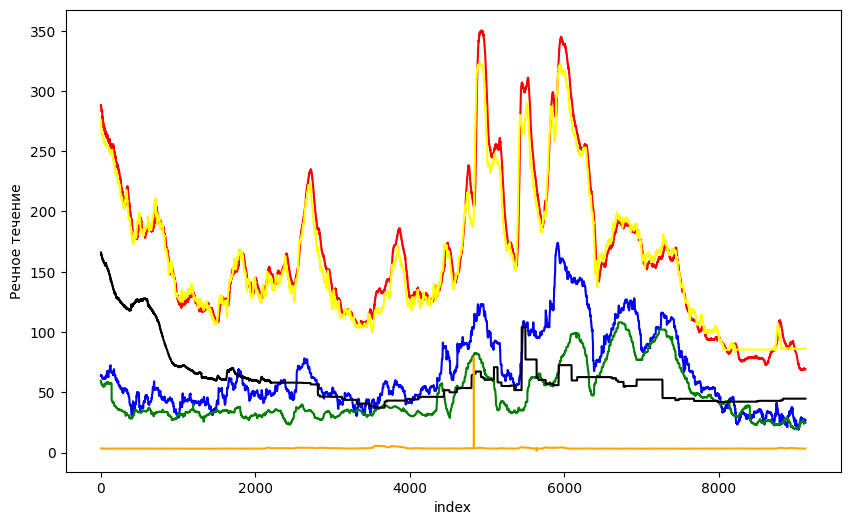

In [77]:
colors = ["red", "blue", "green", "yellow", "black", "orange"]

plt.figure(figsize=(10, 6))
plt.xlabel("index")
plt.ylabel("Речное течение")
for color, item in zip(colors, col1):
    plt.plot(df["id"], df[item], color)

plt.show()    

Видно, что в датасете имеются реки как с индексом речного потока, слабо меняющимся, так и с сильно меняющимся с течением времени.

Также можно сказать, что две реки имеют очень схожие графики зависимости индекса речного потока от времени наблюдения. Возможно, соответствующие признаки для одной из рек можно удалить и предсказывать ее индекс по признакам второй реки.

Рассмотрим корелляцию индексов течения реки для рек, взяв матрицу корелляций для нулевого наблюдения.

In [78]:
import os
from scipy.io import arff


def dt(path):
    df = arff.loadarff(path)
    df = pd.DataFrame(df[0])
    return df


d = 64
df = dt("./river_flow.arff")
df = df.dropna(axis=0)
X = (df.iloc[:, : d])
y = (df.iloc[:, d :])
y.head()

,CHSI2_48H__0,NASI2_48H__0,EADM7_48H__0,SCLM7_48H__0,CLKM7_48H__0,VALI2_48H__0,NAPM7_48H__0,DLDI4_48H__0
60,259.0,3.16,251.0,174.0,67.5,8.92,149.0,57.1
61,258.0,3.18,250.0,174.0,67.6,9.16,148.0,57.3
62,259.0,3.18,250.0,173.0,68.1,8.99,148.0,57.3
63,260.0,3.18,250.0,173.0,67.9,8.99,148.0,57.3
64,259.0,3.18,250.0,173.0,68.1,8.99,147.0,57.3


<AxesSubplot: >

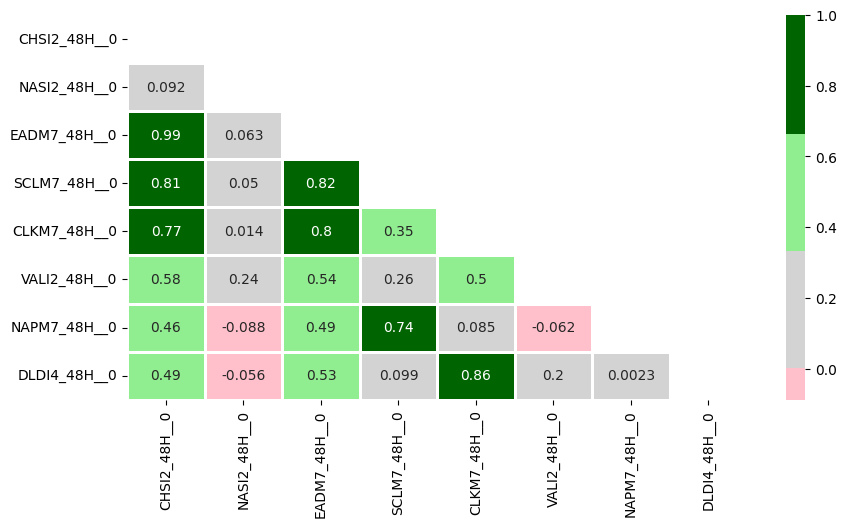

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mask = np.triu(np.ones_like(y.corr(), dtype=bool))
sns.heatmap(y.corr(),
            annot=True,
            mask=mask,
            ax=ax,
            center=0,
            linewidths=1,
            vmax=1,
            cmap=["yellow", "orange", "pink", "lightgrey", "lightgreen", "darkgreen"])

Из матрицы видно, что индексы течения рек для двух рек действительно очень кореллируют друг с другом. 
Значит, при чистке данных можно удалить признаки, соответствующие реки EADM7.

### Data cleaning

Удалим признаки, связанные с рекой EADM7.

In [81]:
df = df.drop(columns={"EADM7__0", "EADM7__-6", "EADM7__-12", "EADM7__-24",
                      "EADM7__-36", "EADM7__-48", "EADM7__-60"})
df.shape

(9005, 65)

### Разбиение данных и масштабирование

In [83]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (6753, 64)
Shape of X_test:  (2252, 64)
Shape of y_train:  (6753, 8)
Shape of y_test:  (2252, 8)


### Обучение моделей

In [84]:
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score


steps = [
    ("scalar", StandardScaler()),
    ("model", Ridge(random_state=42))
]

pipe = Pipeline(steps)

alpha_grid = np.logspace(-100, 100, 20)
searcher = GridSearchCV(pipe, [{"model__alpha": alpha_grid}], scoring="r2", cv=5)
searcher.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model', Ridge(random_state=42))]),
             param_grid=[{'model__alpha': array([1.00000000e-100, 3.35981829e-090, 1.12883789e-079, 3.79269019e-069,
       1.27427499e-058, 4.28133240e-048, 1.43844989e-037, 4.83293024e-027,
       1.62377674e-016, 5.45559478e-006, 1.83298071e+005, 6.15848211e+015,
       2.06913808e+026, 6.95192796e+036, 2.33572147e+047, 7.84759970e+057,
       2.63665090e+068, 8.85866790e+078, 2.97635144e+089, 1.00000000e+100])}],
             scoring='r2')

In [85]:
import time


mo_regr = MultiOutputRegressor(searcher)
start_mo_regr = time.time()
mo_regr.fit(X_train, y_train)
mo_regr_train_time_diff = time.time() - start_mo_regr

y_pred_train = mo_regr.predict(X_train)
mo_regr_accuracy_train = r2_score(y_train, y_pred_train)
print("r2 score обучение Ridge model и multioutput regression: ", mo_regr_accuracy_train)

y_pred = mo_regr.predict(X_test)
mo_regr_accuracy_test = r2_score(y_test, y_pred)
print("r2 score проверка Ridge model и multioutput regression: ", mo_regr_accuracy_test)

r2 score обучение Ridge model и multioutput regression:  0.8318809585423473
r2 score проверка Ridge model и multioutput regression:  0.757419292850752


In [86]:
regr_ch = RegressorChain(searcher).fit(X_train, y_train)
start_regr_ch = time.time()
regr_ch.fit(X_train, y_train)
regr_ch_train_time_diff = time.time() - start_regr_ch

y_pred_train = regr_ch.predict(X_train)
regr_ch_accuracy_train = r2_score(y_train, y_pred_train)
print("r2 score обучение Ridge model и regressor chain: ", regr_ch_accuracy_train)

y_pred = regr_ch.predict(X_test)
regr_ch_accuracy_test = r2_score(y_test, y_pred)
print("r2 score проверки Ridge model и regressor chain: ", regr_ch_accuracy_test)

r2 score обучение Ridge model и regressor chain:  0.8319092321447996
r2 score проверки Ridge model и regressor chain:  0.7595552730086752


### Сравнение моделей

In [118]:
models = [("Multioutput regressor", mo_regr_accuracy_train, mo_regr_accuracy_test, mo_regr_train_time_diff),
          ("Regressor chain", regr_ch_accuracy_train, regr_ch_accuracy_test, regr_ch_train_time_diff)
         ]

predict = pd.DataFrame(data=models, columns=["Модель", "Обучение R2", "Проверка R2", "Время обучения"])
print(predict)

                  Модель  Обучение R2  Проверка R2  Время обучения
0  Multioutput regressor     0.831881     0.757419       44.623329
1        Regressor chain     0.831909     0.759555       19.748531


- Стратегия Regressor Chain показала немного более высокое значение метрики R2, чем Multioutput regressor
- В целом обе модели показали высокую точность
- Также Regressor Chain быстрее обучилась